In [63]:
using Pkg
using Revise

Pkg.activate("..")

# Pkg.update("FoodWebs")

using CairoMakie, GeometryBasics
using NetworkLayout
using GraphMakie, Graphs, MetaGraphs
using ColorSchemes

using FoodWebs
using LinearAlgebra
using StatsBase, Polynomials, Random
using JLD2
using UUIDs

using DelimitedFiles

using ProfileVega

using OrdinaryDiffEq
using PreallocationTools


fw = FoodWebs

  Activating project at `~/Projects/Working/HIFMB/TempRanges`


FoodWebs

# Introduction

In this notebook I will outline the simulation steps looking at the effects of shifts in species ranges with climate change. First I will describe the simulation procedure and then show some results. 

In [64]:
#1) GENERATE SPECIES POOL
N_pool = 25
@time sp_vec = fw.species(0.1, N_pool);

  0.000095 seconds (65 allocations: 7.547 KiB)


In [65]:
using Distributions

function exp_parameters(N::Int64, M::Int64)
    #exponent
    γ = rand(Uniform(0.8, 1.5), N, M) #[0.8, 1.5]
    λ = ones(N,N) # 1
    μ = rand(Uniform(1.0, 2.0), N, M) #[1.0, 2.0] 
    ϕ = rand(Uniform(0.0, 1.0), N, M) #[0.0, 1.0]
    ψ = rand(Uniform(0.5,1.1), N, M) #[0.5, 1.2]

    return [fw.ExponentialParameters(γ[:,i], λ, μ[:,i], ϕ[:,i], ψ[:,i]) for i = 1:M]
end

exp_parameters(com::fw.Community, M::Int64) = exp_parameters(com.N, M)

exp_parameters (generic function with 2 methods)

In [66]:
Nvec = [10, 20, 30]
Nrep = 500
psw = zeros(Nrep, length(Nvec))
# coms = Array{fw.Community, 1}(undef, Nrep)

for (i,N) in enumerate(Nvec)
    print(N)
    for j = 1:Nrep
        coms = fw.community(N,0.2)
        psw[j, i] = fw.proportion_stable_webs(coms,exp_parameters, N_trials = 100)
    end
end

102030

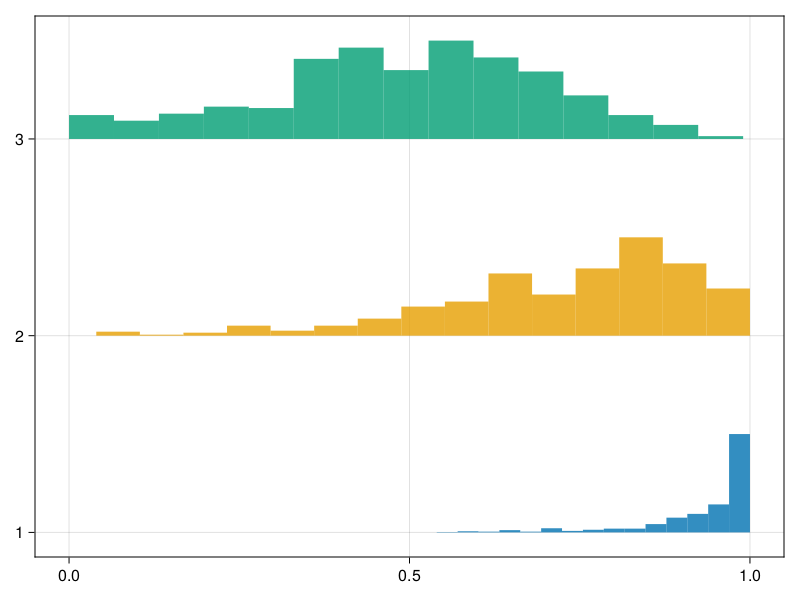

In [67]:
fig = Figure()
ax = Axis(fig[1,1])

for i = eachindex(Nvec)
    hist!(ax, psw[:,i], offset = i,  scale_to=0.5)

end

fig

In [68]:
Nvec = range(0.1,3.0, length=3)
Nvec = vcat(Nvec, fill(5.0, 3))
Nrep = 100
psw = zeros(Nrep, length(Nvec))
m_ = similar(psw)
# coms = Array{fw.Community, 1}(undef, Nrep)

for (i,m) in enumerate(Nvec)
    println(m)
    for j = 1:Nrep
        fniche(N...) = rand(Beta(Nvec[i] ,Nvec[end - i + 1]), N...)
        coms = fw.community(30,0.2,fn = fniche)
        m_[j, i] = mean(coms.n)
        psw[j, i] = fw.proportion_stable_webs(coms,exp_parameters, N_trials = 100)
    end
end

0.1
1.55
3.0
5.0
5.0
5.0


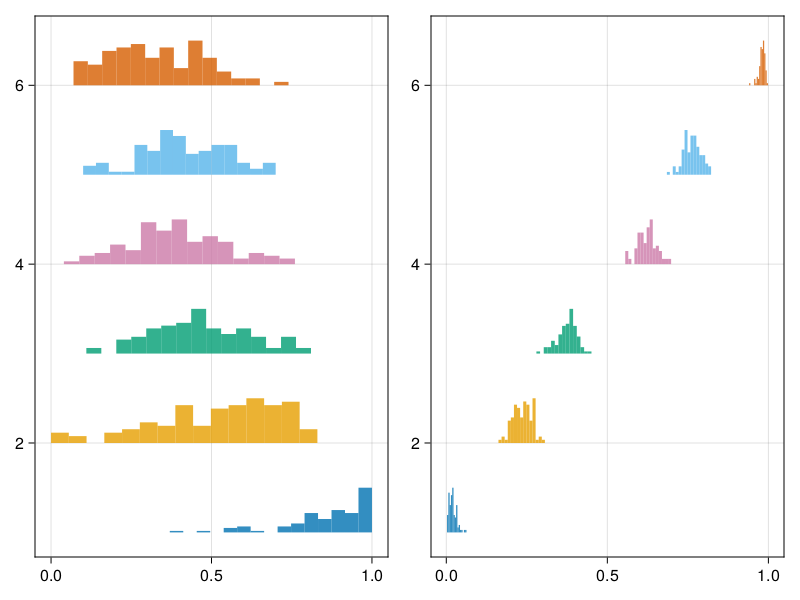

In [69]:
fig = Figure()
ax1 = Axis(fig[1,1])
ax2 = Axis(fig[1,2])
for i = eachindex(Nvec)
    hist!(ax1, psw[:,i], offset = i,  scale_to=0.5)
    hist!(ax2, m_[:,i], offset = i,  scale_to=0.5)
end

fig

# Kinetic Model
Below is the code to recover the kinetic model from a set of generalised model parameters.

## Example 1: stable system


In [70]:
Random.seed!(6)

N = 30
com = fw.community(N, 0.3)
J = zeros(N,N)
stable = true

p = 0
 
while stable
    com = fw.community(N, 0.3)
    p = fw.generalised_parameters(com,1,exp_parameters)[1];
    fw.generalised_jacobian!(J, p)
    λ = eigen(J).values[end]
    println(λ)
    
    if λ.re < 0
        stable = false
    end
end

k = fw.get_kineticparams(p);

0.01374782116888524 + 0.0im
0.02822821279376347 + 0.06438565955359832im
-4.930200033809347e-5 + 0.06086508067082461im


In [71]:
Random.seed!(2)
u0 = ones(k.N) 
tspan = (0.0, 1e3)
prob = ODEProblem(fw.dx!, u0, tspan, (k, LazyBufferCache()))

@time sol = solve(prob, AutoTsit5(Rosenbrock32(autodiff = true)), callback = PositiveDomain(), saveat = 0.1)

series(sol.t, sol[:,:], solid_color = "black")

LoadError: UndefVarError: `PositiveDomain` not defined

In [72]:
using Random
Random.seed!(1)

N = 30
u0 = rand(N)

Nrep = 3

com = fw.community(N, 0.3)
p = fw.generalised_parameters(com, Nrep , exp_parameters)
k = fw.get_kineticparams.(p)

# u0 = ones(N) + 1e-4randn(N)
tspan = (0.0, 1e4)
prob = [ODEProblem(fw.dx!, u0, tspan, (kp, LazyBufferCache())) for kp = k]

sol = [solve(p, AutoTsit5(Rosenbrock32(autodiff = true)), callback = PositiveDomain()) for p = prob];

LoadError: UndefVarError: `PositiveDomain` not defined

In [73]:
J = zeros(N,N)
for i = 1:Nrep
    fw.generalised_jacobian!(J, p[i])
    println(eigen(J).values[end])
end

0.06723616913602126 + 0.6726813835456483im
0.04869338404275693 + 0.6876920159942659im
0.07666043724364027 + 0.6650301296515361im


In [74]:
f = Figure()


for i = 1:Nrep
    ax = Axis(f[i,1])
    series!(ax, sol[i].t, (sol[i][:,:]), solid_color = "black")
end
f

LoadError: UndefVarError: `sol` not defined

In [75]:
sample_lat(1000) |> hist

LoadError: UndefVarError: `sample_lat` not defined

## Example 3: Metacommunity

In [76]:
get_p(D, x, r) = cdf(D,x+r) - cdf(D,x-r)

f = Figure()
ax = [Axis(f[i, 1]) for i = 1:5]

Mvec = range(1.0,42.0, length = 5)
dvec = 0.0:0.001:1.0

axM = Axis(f[1:5, 2])
hist!(Mvec)

for i = 1:5
    α = range(0.0, 0.75,length=5)[i]
    μ = 0.5(Mvec.^ α) ./ maximum(Mvec .^ (α))
    σ = 0.1(Mvec.^ α) ./ maximum(Mvec .^ (α))
    dD = Truncated.(Normal.(μ, σ), 0.0, 1.0)

    println(mean.(dD))
    k = hcat([get_p.(Ref(d), dvec, 0.01) for d = dD]...)

    series!(ax[i], (dvec), k', solid_color = :black)
    text!(ax[i], 0.8,0.5 , text = string(α))
    ylims!(ax[i], 0 , 1)
end

f

LoadError: UndefVarError: `Normal` not defined

In [77]:
u0 = ones(k.N) + 1e-4randn(k.N)
tspan = (0.0, 2e4)
prob = ODEProblem(fw.dx!, u0, tspan, (k,LazyBufferCache()))
sol = solve(prob, AutoTsit5(Rosenbrock32(autodiff = true)), callback = PositiveDomain())
series(sol.t, sol[:,:], solid_color = "black")

LoadError: type Array has no field N

# Sampling size

How do we generate communities allong latitude gradients in a way that reflects the decreasing area at high latitudes?

This is just some basic trigonometry. First we consider a sphere the radius of $r$. The area of a spherical cap in terms of the latitude $\phi$ is:

$$
A = 2 \pi r^2 (1 - \sin(\phi))
$$

with the area of the total hemisphere when $\theta = 0$ being $A_T = 2 \pi r^2$. The ratio of these thus gives the cumulative proportion of the curved area above the latitude $\phi$. This can the thought of as a probablity distribution giving the CDF of the latidues of all points over the sphere:

$$
F_\Phi(\Phi > \phi) = 1 - \frac{A}{A_T} = 1 - \frac{2 \pi r^2 (1 - \sin(\phi))}{2 \pi r^2} = \sin{\phi}
$$

which is all we need to generate point distributed over the sphere. 

In [280]:
fig = Figure(resolution = (1000, 500))

ax3 = Axis3(fig[1,1], aspect=(1,1,1), perspectiveness=0.75, azimuth = 1)
n = 1000            # large enough for meaningful tests
z = rand(n)         # uniform on [-1, 1]
ϕ = asin.(z)    # uniform on [-pi, pi]
λ = (π / 2) .* rand(n)

x = cos.(ϕ) .* cos.(λ)
y = cos.(ϕ) .* sin.(λ)
z = sin.(ϕ)

mesh!(ax3, Sphere(Point3f(0.0), 1.0) ,color = (:grey, 1.0), shading = true)
scatter!(ax3, Point3f.(x,y,z), color = ϕ)
lines!(ax3, Circle(Point2f(0.0),1.0), color = "red")

ax4 = Axis3(fig[1,2][1,1], aspect=(1,1,1), perspectiveness=0.75)
#plot sphere
mesh!(ax4, Sphere(Point3f(0.0), 1.0) ,color = (:cornflowerblue, 0.1), shading = true)
#plot small circle
r = sqrt(1 - 0.5^2)
sc = [Point3f(r*sin(θ),r*cos(θ),0.5) for θ = range(π,-π, length = 100)]
lines!(ax4, sc, color = "red")

#plot triangle
triangle = [Point3f(0,0,0), Point3f(0,0,0.5), Point3f(r,0,0.5),Point3f(0,0,0)]
lines!(ax4, triangle, color = "blue")
scatter!(ax4, triangle, color = "black")

text!([Point3f(-0.1,0.1,0.1), Point3f(-.1,.1,0.6), Point3f(r + 0.1,0,0.5)],
    text = ["a","b","c"],
    align = (:left, :baseline),
    fontsize = 20)


ax5 = Axis(fig[1,2][2,1])
hist!(ax5, l, normalization = :pdf, color = (:cornflowerblue, 0.4))
lines!(ax5, range(0,π/2,length = 100), cos.(range(0,π/2,length = 100)), color = "black")
hist!(ax5, asin.(rand(10000)), normalization = :pdf, color = (:orange, 0.4))

fig

LoadError: UndefVarError: `l` not defined

# Dispersal Simulations

In [216]:
#function to convert uniform RV to latitudes
function sample_longlat(N)
    lat = range(0,1,length = N)
    # lat = rand(N)
    tuple.(ones(N), asin.(lat))
end

lonlat = sample_longlat(50)

50-element Vector{Tuple{Float64, Float64}}:
 (1.0, 0.0)
 (1.0, 0.020409580174174)
 (1.0, 0.04082766818170322)
 (1.0, 0.061262803828054616)
 (1.0, 0.08172359119750706)
 (1.0, 0.10221873163591444)
 (1.0, 0.1227570577650129)
 (1.0, 0.14334756890536535)
 (1.0, 0.16399946831500462)
 (1.0, 0.1847222026902331)
 (1.0, 0.20552550442529366)
 (1.0, 0.2264194371906321)
 (1.0, 0.24741444546766753)
 ⋮
 (1.0, 0.8875228296027609)
 (1.0, 0.9205230201405152)
 (1.0, 0.9550221436509135)
 (1.0, 0.9912929239228018)
 (1.0, 1.0296968008377507)
 (1.0, 1.0707305405972887)
 (1.0, 1.115109958627807)
 (1.0, 1.1639348462527304)
 (1.0, 1.2190588266094466)
 (1.0, 1.2841011889841658)
 (1.0, 1.3684206412277997)
 (1.0, 1.5707963267948966)

In [267]:
#generate inital metacommunity
Random.seed!(2)
mc = fw.stable_metacommunity(30,0.2,lonlat, R = 42.0, fexp = exp_parameters, verbose = true, max_draws = 1, vk = 1000, psw_threshold = 0.75)

draw:0 psw: [0.22, 0.29, 0.47, 0.59, 0.44, 0.33, 0.49, 0.52, 0.4, 0.65, 0.55, 0.63, 0.24, 0.06, 0.8, 0.6, 0.55, 0.67, 0.07, 0.83, 0.19, 0.5, 0.62, 0.59, 0.37, 0.7, 0.64, 0.57, 0.51, 0.74, 0.39, 0.72, 0.58, 0.78, 0.46, 0.1, 0.35, 0.58, 0.54, 0.37, 0.38, 0.36, 0.54, 0.09, 0.6, 0.56, 0.56, 0.27, 0.1, 0.57]
draw:1 psw: [0.22, 0.29, 0.47, 0.59, 0.44, 0.33, 0.49, 0.52, 0.4, 0.65, 0.55, 0.63, 0.24, 0.06, 0.8, 0.6, 0.55, 0.67, 0.07, 0.83, 0.19, 0.5, 0.62, 0.59, 0.37, 0.7, 0.64, 0.57, 0.51, 0.74, 0.39, 0.72, 0.58, 0.78, 0.46, 0.1, 0.35, 0.58, 0.54, 0.37, 0.38, 0.36, 0.54, 0.09, 0.6, 0.56, 0.56, 0.27, 0.1, 0.57]


MetaCommunity M:50 FoodWebs.Community Sp: 1500

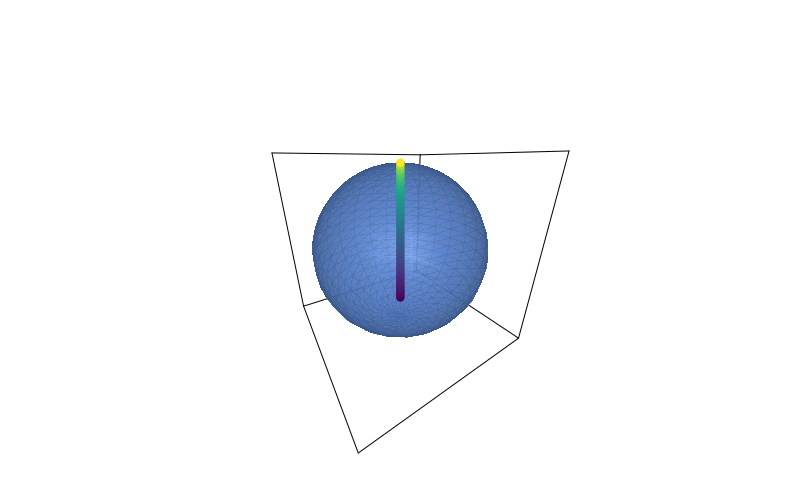

In [268]:
fig = Figure(resolution = (800, 500))

λ = [l[1] for l = lonlat]
ϕ = [l[2] for l = lonlat]

x = cos.(ϕ) .* cos.(λ)
y = cos.(ϕ) .* sin.(λ)
z = sin.(ϕ)

ax3 = Axis3(fig[1,1], aspect=(2,2 ,2), perspectiveness=1.0, azimuth = 1, elevation = π/8, viewmode = :fitzoom)
mesh!(ax3, Sphere(Point3f(0.0), 1.0) ,color = (:cornflowerblue, 0.7), shading = true)
scatter!(ax3, Point3f.(x,y,z), color = ϕ)
# lines!(ax3, Circle(Point2f(0.0),1.0), color = "red")
hidedecorations!(ax3)


fig

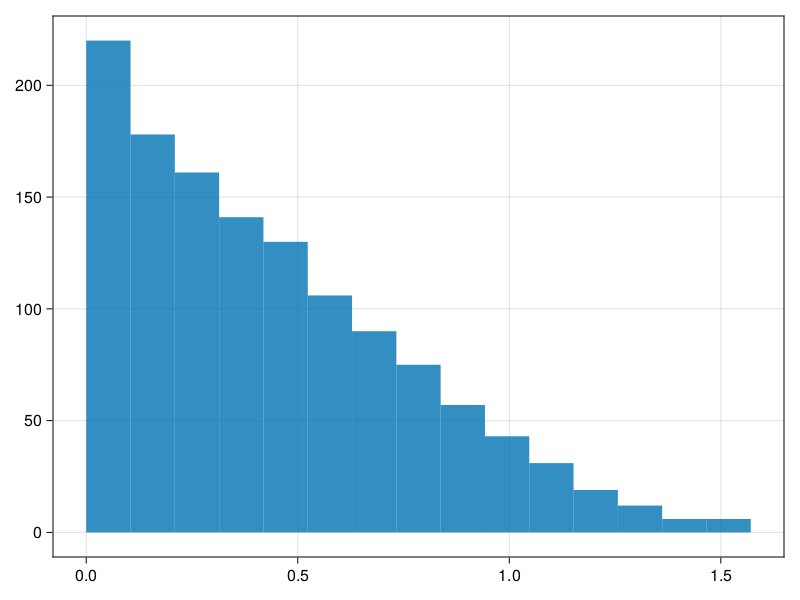

In [269]:
filter(x-> !isinf(x), mc.D) |> hist

In [540]:
#simulate dispersal
Random.seed!(1)

psw = zeros(length(mc.loc),2,2)

mc_prob = deepcopy(mc)
mc_random = deepcopy(mc)

psw[:,1,1] .= fw.proportion_stable_webs(mc_prob, exp_parameters)
psw[:,1,2] .= fw.proportion_stable_webs(mc_random, exp_parameters)

fw.multiple_dispersal!(mc_prob, p_dispersal = :a, d_dispersal = :p, αd = .75)
fw.multiple_dispersal!(mc_random, p_dispersal = :a, d_dispersal = :p, αd = .0)

psw[:,2,1] .= fw.proportion_stable_webs(mc_prob, exp_parameters)
psw[:,2,2] .= fw.proportion_stable_webs(mc_random, exp_parameters)

fig = Figure()

for i = 1:2
    for j = 1:2
        ax = Axis(fig[i,j])
        scatter!(ax, ϕ, psw[:,i,j])
    end
end

linkaxes!(fig.content...)

fig

LoadError: InterruptException:

In [270]:
Mall = hcat([[sp.M[1] for sp = c.sp] for c = mc.coms]...)[:] |> sort

1500-element Vector{Float64}:
  1.009921326123731
  1.014730069922249
  1.020415645498888
  1.0206372715047791
  1.0238971610238277
  1.02595063682835
  1.0265865090577329
  1.0395787415203577
  1.0398248254985971
  1.0418702309595753
  1.0422722437022602
  1.0446761770033253
  1.0446909961133202
  ⋮
 40.866458633213895
 40.89783894438158
 41.027957035757304
 41.286655036943316
 41.34101310814334
 41.467727198093364
 41.5802524763154
 41.69419310156972
 41.72025014618707
 41.87716422482077
 41.892963358332665
 41.90225879692719

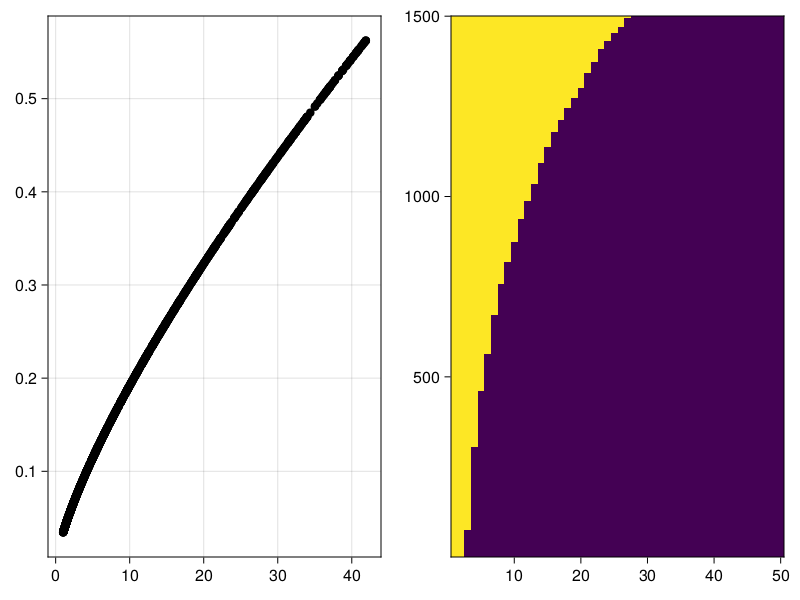

In [271]:
# Mall = hcat([[sp.M[1] for sp = c.sp] for c = mc.coms]...)[:] |> sort

αd = 0.75

# Mall = range(0.01, 4 .^ 42.0, length = 1000)
max_d = [ 0.1 ^ (1.0 - αd) * (M ./ maximum(Mall)) .^ αd for M = Mall]
D_mat = hcat([[D .< m_d for D = eachrow(mc.D[sortperm(mc.T_mat[:]), sortperm(mc.T_mat[:])])] for m_d = max_d]...)


fig = Figure()
plot!(Axis(fig[1,1]), (Mall)[:], max_d[:])
heatmap!(Axis(fig[1,2]), hcat(D_mat[1,:]...))
fig

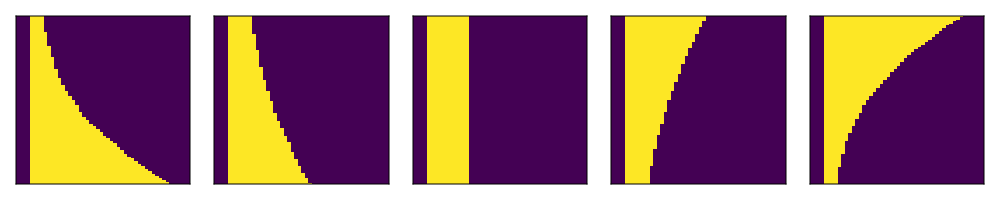

In [274]:
αd = range(-0.75, 0.75, length = 5)

Mall_mc = hcat([[sp.M[1] for sp = c.sp] for c = mc.coms]...)[:] |> sort
Mall = range(0.01, 1.0, length = 1000)
max_d = [[ 0.25 * (M ./ median(Mall_mc)) .^ a for M = Mall_mc] for a = αd]
D_mat = [hcat([[D .< m_d for D = eachrow(mc.D[sortperm(mc.T_mat[:]), sortperm(mc.T_mat[:])])] for m_d = a]...) for a = max_d]


fig = Figure(resolution = (1000, 200))
[heatmap!(Axis(fig[1,i]), hcat(D_mat[i][5,:]...)) for i = eachindex(αd)]
hidedecorations!.(fig.content)
fig

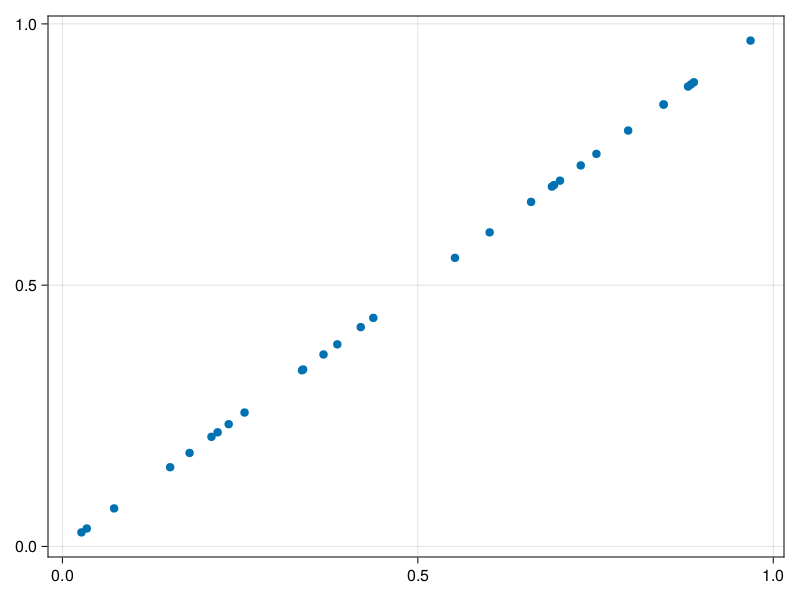

In [279]:
n = [sp.n for sp = mc.coms[2].sp]
prod = [sp.producer[1] for sp = mc.coms[2].sp]
M = [sp.M[1] for sp = mc.coms[2].sp]
TL = mc.coms[2].TL


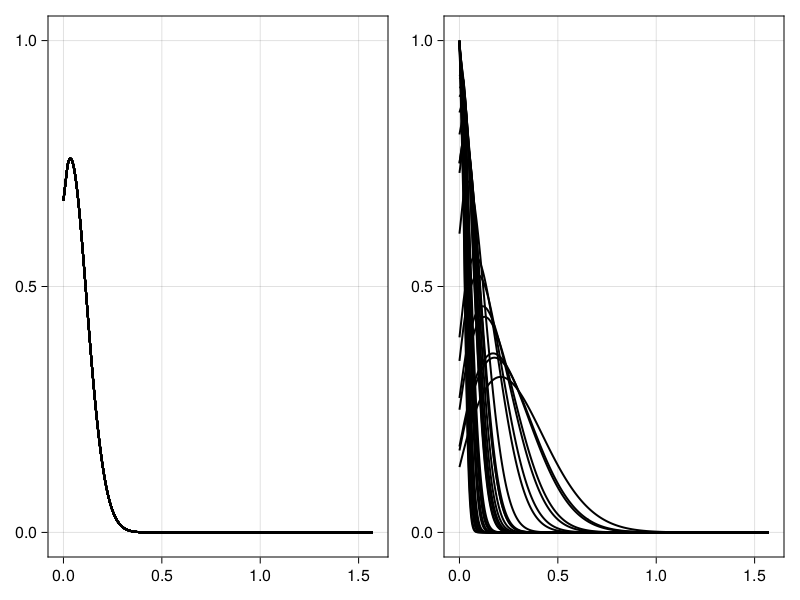

In [969]:
r = 0.15
b0 = 0.1
c0 = 0.0

σ0 =  c0 .+ b0 * ((Mall./mean(Mall)) .^ 0.0) 
σ =  c0.+ b0 * ((Mall./mean(Mall)) .^ 0.75)

dD0 = Truncated.(Rayleigh.(σ0),0,π/2 + r)
dD = Truncated.(Rayleigh.(σ),0,π/2 + r)

d = filter(x -> !isinf(x), mc.D[:]) |> sort
get_p(D, x, r) = cdf(D,x+r) - cdf(D,x)

p0 = hcat([get_p.(D, d, r) for D = dD0]...)
p = hcat([get_p.(D, d, r) for D = dD]...)

fig = Figure()

ax0 = Axis(fig[1,1])
series!(ax0,d, p0', solid_color = :black)

ax = Axis(fig[1,2])
series!(ax,d, p', solid_color = :black)

linkaxes!(ax,ax0)

fig

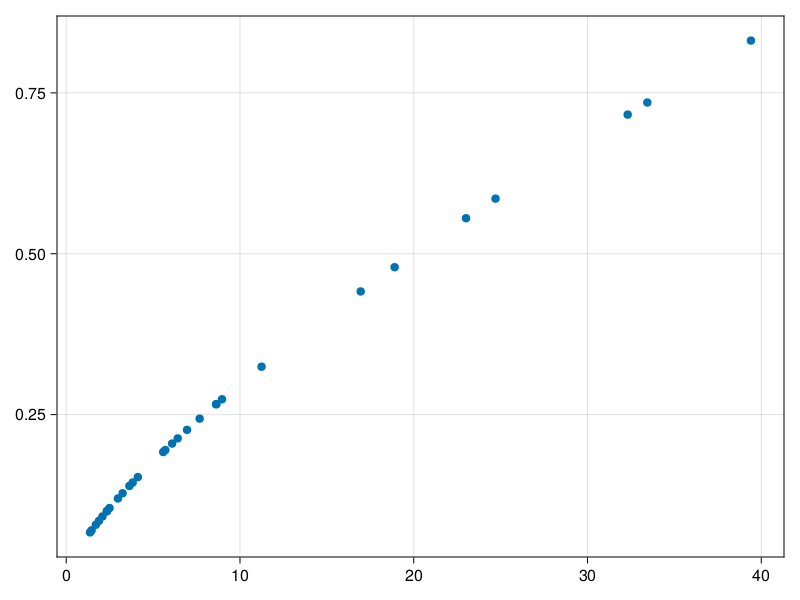

In [919]:
scatter(Mall, 0.2 * (Mall/median(Mall)) .^ 0.75)

In [835]:
d = 0.0:0.01:π/2
maxD = 0.1 * sort(Mall) .^ 0.75

(d .< maxD') * 0.2

158×30 Matrix{Float64}:
 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  …  0.2  0.2  0.2  0.2  0.2  0.2  0.2
 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2     0.2  0.2  0.2  0.2  0.2  0.2  0.2
 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2     0.2  0.2  0.2  0.2  0.2  0.2  0.2
 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2     0.2  0.2  0.2  0.2  0.2  0.2  0.2
 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2     0.2  0.2  0.2  0.2  0.2  0.2  0.2
 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  …  0.2  0.2  0.2  0.2  0.2  0.2  0.2
 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2     0.2  0.2  0.2  0.2  0.2  0.2  0.2
 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2     0.2  0.2  0.2  0.2  0.2  0.2  0.2
 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2     0.2  0.2  0.2  0.2  0.2  0.2  0.2
 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2     0.2  0.2  0.2  0.2  0.2  0.2  0.2
 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  …  0.2  0.2  0.2  0.2  0.2  0.2  0.2
 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2     0.2  0.2  0.2  0.2  0.2  0.2  0.2
 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2 

In [830]:
d[1]

0.0

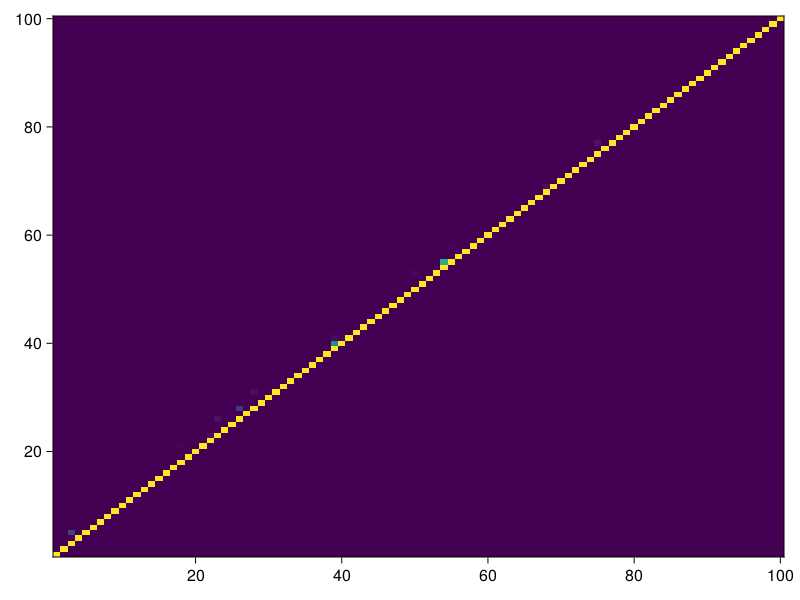

In [764]:
σ =  c0 + b0 * ((1.0/maximum(Mall)) ^ 0.75)

dD = Truncated(Rayleigh(σ),0,π/2 + r)
p = get_p.(dD, mc.D, r)

heatmap(p)

In [705]:
mean(p)

0.11965418303656307

In [706]:
mean(p0)

0.12213094461157743

In [605]:
μ

30-element Vector{Float64}:
 -0.0019974557636271983
 -0.024054143368498426
 -0.0014223471582516245
 -0.005941120964717328
 -0.02321527517356836
 -0.0007188068091970035
 -0.008326739572555919
 -0.05142637001787742
 -0.049169982417567315
 -0.06159579184228825
 -0.029273513179895794
 -0.0400454535228052
 -0.006933350983960418
  ⋮
 -0.0004982135620600348
 -0.023263738103145304
 -0.008995806020286823
 -0.04319572900553492
 -0.010030991615297857
 -0.014779402994488988
 -0.004174570626789498
 -0.003563981447539999
 -0.020775979571981296
 -0.0026954074493033
 -0.0036878079557658427
 -0.015146424972531491

In [489]:
α = randn(10000) .+ 10
Mvec = 10.0

D = Mvec .^ α

var(log.(D))

5.382161312281922

In [490]:
(1.0^2 * log(10)^2)

5.301898110478399

In [482]:
var(α)

0.9200621580993089

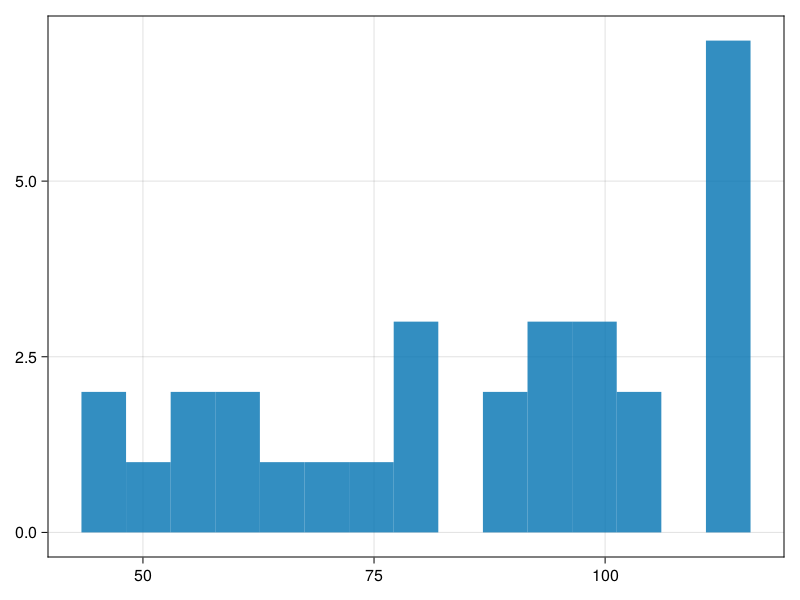

In [462]:
sum(p, dims = 1)[:] |> hist

In [1083]:
#calculate eigenvalues and 
Random.seed!(1)
# function get_GeneralisedParams(com, K)
com = mc_random.coms[end-1]
K = 10

gp = fw.generalised_parameters(com, K, exp_parameters)
λ = Vector{Eigen}(undef, K)
J = zeros(com.N,com.N)

for i = eachindex(gp)
    fw.generalised_jacobian!(J,gp[i])
    λ[i] = eigen!(J)
    println(λ[i].values[end])
end

-0.11227902003655707 + 0.04131747871710048im
0.009499436235127291 + 0.0im
-0.0681103440188083 + 0.028659052129285493im
0.042901739838390705 + 0.0im
0.1569521635624373 + 0.0im
0.024629184779538436 + 0.0im
0.09357995019628412 + 0.0233724447057423im
0.018990210467564893 + 0.6776725850720291im
-0.019891981356272244 + 0.0im
0.13001601487457148 + 0.0im


In [1097]:
#simulate dynamics of unstable systems
Random.seed!(1)
re = map(x -> x.values[end].re, λ)
sols = Vector{Any}(undef, K) .= Ref(ones(com.N))
for i = eachindex(re)
    if re[i] > 0
        k = fw.get_kineticparams(gp[i])
    
        #integrate
        u0 = ones(k.N) + 0.1randn(k.N)
        tspan = (0.0, 1e3)
    
        cb = CallbackSet(PositiveDomain(), TerminateSteadyState())
        println(i)
        prob = ODEProblem(fw.dx!, u0, tspan, (k, LazyBufferCache()))
        sols[i] = solve(prob, callback = cb)
    end
end

2
4
5
6
7
8
10


┌ Warning: Instability detected. Aborting
└ @ SciMLBase ~/.julia/packages/SciMLBase/iwGOQ/src/integrator_interface.jl:606


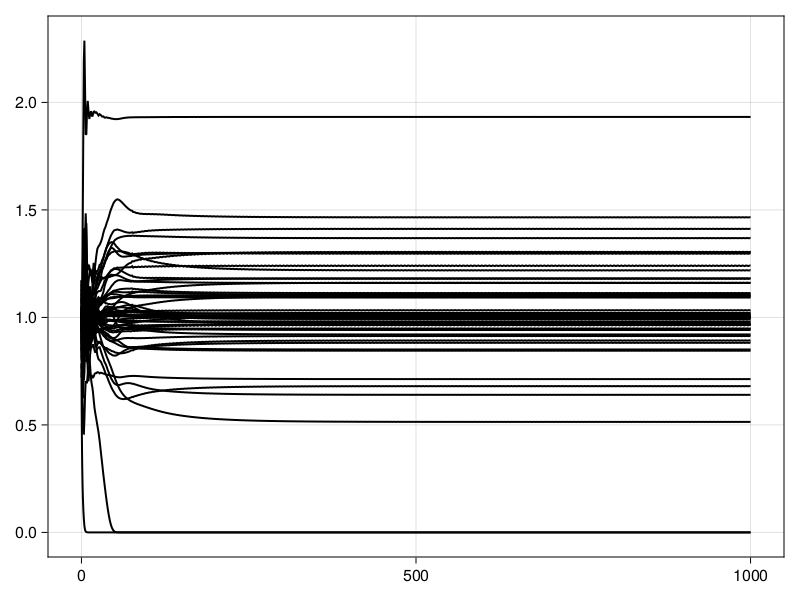

In [1098]:
#find community with the most extinctions
# i = findmax(map(x -> sum(x[end] .== 0.0), sols))[2]
i = 2
series(sols[i].t , sols[i][:,:], solid_color = "black")

In [1099]:
to_remove = findall(sols[i][end] .< eps()) 

new_com = deepcopy(com)
for i = eachindex(to_remove)
    new_com = fw.remove_species(new_com, com.ids[to_remove[i]])
end

new_com

FoodWebs.Community N:51 T:1.3897820110237737

## Plotting Webs

In [1100]:
#Metrics  
function get_shortestpath(g)
    prod = findall(g.gprops[:prod])
    src = 1:size(g)[1]
    
    d = Matrix{Any}(undef, length(src), length(prod))
    
    for i = eachindex(src)
        for j = eachindex(prod)
            d[i,j] = length(Graphs.a_star(g, src[i], prod[j]))
            d[i,j] = d[i,j] == 0 ? Inf : d[i,j]
            if i == prod[j]
                d[i,j] = 0
            end
        end

        if all(d[i,:] .== Inf)
            d[i,:] .= 1.0
        end
    end
    
    tl = (minimum(d,dims=2) .+ 1)[:]

    # return(tl ./ maximum(tl))
end

function get_TL(g)
    #calculate χ
    N = size(g)[1]
    A = adjacency_matrix(g)
    
    χ = A ./ (norm.(eachrow(A), 1))
    χ[isnan.(χ)] .= 0.0
    
    A = I(N) - χ'
    TL = ones(1, N) * inv(A) 
    return(TL[:])
end

get_TL (generic function with 1 method)

In [1101]:
function bin_vec(x; min_val = minimum(x), max_val = maximum(x), nbins = 10)
    #get bin boundaries
    boundaries = range(min_val, max_val + eps(),length = nbins)

    #itterate through and get bins
    y = similar(x)
    for i = eachindex(x)
        y[i] = findfirst((x[i] .- boundaries) .<= 0)
    end

    return(y)
end

function space_bins(bins)
    bins_dict = Dict(k => 1 for k = unique(bins))
    x_pos = similar(bins)

    for i = eachindex(bins)
        x_pos[i] = bins_dict[bins[i]]
        bins_dict[bins[i]] += 1
    end

    #normalise in each group
    for g = unique(bins)
        indx = findall(bins .== g)
        x_pos[indx] .= (x_pos[indx] .- mean(x_pos[indx]))
    end

    return(x_pos)

end



space_bins (generic function with 1 method)

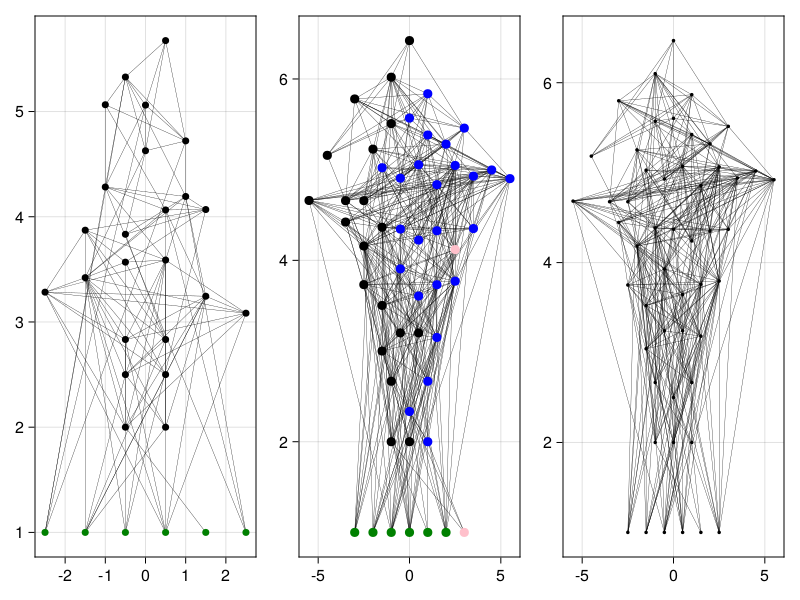

In [1102]:
function foodweb_layout(g)
    # ny = rand(size(g)[1])
    # ny = get_shortestpath(g)
    ny = get_TL(g)
    
    #bin
    bin_n = bin_vec(ny)
    nx = space_bins(bin_n)
    
    # nx = g.gprops[:n]
    return(Point.(zip(nx, ny)))
end

#convert to graphs
g_vec = Vector{Any}(undef, 3)
for (i,sc) = enumerate([mc.coms[end-1], com, new_com])
    g = MetaDiGraph(SimpleDiGraph(sc.A))
    set_prop!(g, :n, [x.n for x = sc.sp])
    set_prop!(g, :c, [x.c for x = sc.sp])
    set_prop!(g, :r, [x.r for x = sc.sp])
    set_prop!(g, :prod, [x.producer[1] for x = sc.sp])
    
    g_vec[i] = g
end

f = Figure()

ax1 = Axis(f[1,1])
prod = findall([x.producer[1] for x = mc.coms[end-1].sp])
node_color = [:black for i = 1:mc.coms[end-1].N]
node_color[prod] .= :green
graphplot!(ax1,g_vec[1], layout=foodweb_layout, edge_width = 0.3, arrow_size = 0, node_size = 10, node_color = node_color)

ax2 = Axis(f[1,2])
node_color = [:black for i = 1:com.N]

prod = findall([x.producer[1] for x = com.sp])
new_nodes = findall([x.Tpk != com.T for x = com.sp])

node_color[prod] .= :green
node_color[to_remove] .= :red
node_color[new_nodes] .= :blue
node_color[intersect(to_remove, new_nodes)] .= :pink
graphplot!(ax2,g_vec[2], layout=foodweb_layout, edge_width = 0.3, arrow_size = 0, node_size = 13, node_color = node_color)

ax3 = Axis(f[1,3])
graphplot!(ax3,g_vec[3], layout=foodweb_layout, edge_width = 0.3, arrow_size = 0.0, node_size = 5)


f

# Simulations

In [1487]:
function resolve_extinction(com, K)
    gp = fw.generalised_parameters(com, K, exp_parameters)
    λ = Vector{Eigen}(undef, K)
    J = zeros(com.N,com.N)

    psw = zeros(K)
    N = zeros(K)
    
    for i = eachindex(gp)
        fw.generalised_jacobian!(J,gp[i])
        λ[i] = eigen!(J)
        x = typeof(λ[i].values[end]) <: AbstractFloat ? λ[i].values[end] : λ[i].values[end].re
        if x > 0
            #simulate and get new community
            k = fw.get_kineticparams(gp[i])
            #integrate
            u0 = ones(k.N) + 0.1randn(k.N)
            tspan = (0.0, 1e3)
            cb = CallbackSet(PositiveDomain(), TerminateSteadyState())
            prob = ODEProblem(fw.dx!, u0, tspan, (k, LazyBufferCache()))
            sol = solve(prob, callback = cb)
            
            to_remove = findall(sol[end] .< 1e-6) 

            new_com = deepcopy(com)
            
            for i = eachindex(to_remove)
                new_com = fw.remove_species(new_com, com.ids[to_remove[i]])
            end
            
            psw[i] = fw.proportion_stable_webs(new_com, exp_parameters, N_trials = 20)
            N[i] = new_com.N
        else
            psw[i] = fw.proportion_stable_webs(com, exp_parameters, N_trials = 20)
            N[i] = com.N
        end
    end
    return(psw, N)
end

resolve_extinction (generic function with 1 method)

In [1629]:
N = 20
C = 0.2
Ntemp = 25
Nrep = 1

psw_results = zeros(Ntemp,3,2,Nrep)
N_results = zeros(Ntemp,3,2,Nrep)
temp_results = zeros(Ntemp, Nrep)

mc = 0
mc_prob = 0
mc_random = 0

for r = 1:Nrep
    print(r, "\r")
    θ = sample_lat(Ntemp) |> sort
    temp_results[:,r] .= θ
    
    mc = fw.stable_metacommunity(N,C,θ, fexp = exp_parameters, verbose = false, max_draws = 1000, vk = 1000, psw_threshold = 0.9)    
    mc_prob = deepcopy(mc)
    mc_random = deepcopy(mc)
    
    psw_results[:,1,1,r] .= fw.proportion_stable_webs(mc_prob, exp_parameters)
    psw_results[:,1,2,r] .= fw.proportion_stable_webs(mc_random, exp_parameters)

    N_results[:,1,1,r] .= [c.N for c = mc_prob.coms]
    N_results[:,1,2,r] .= [c.N for c = mc_random.coms]

    #disperse
    fw.multiple_dispersal!(mc_prob, p_dispersal = :r, d_dispersal = :d, αd = .75)
    fw.multiple_dispersal!(mc_random, p_dispersal = :r, d_dispersal = :r, αd = .75)
    
    psw_results[:,2,1,r] .= fw.proportion_stable_webs(mc_prob, exp_parameters)
    psw_results[:,2,2,r] .= fw.proportion_stable_webs(mc_random, exp_parameters)

    N_results[:,2,1,r] .= [c.N for c = mc_prob.coms]
    N_results[:,2,2,r] .= [c.N for c = mc_random.coms]

    #resolve extinctions - single for now?
    for (i,c) = enumerate(mc_prob.coms)
        rc = resolve_extinction(c, 10)
        psw_results[i,3,1,r] = mean(rc[1])
        N_results[i,3,1,r] = mean(rc[2])
    end

    for (i,c) = enumerate(mc_random.coms)
        rc = resolve_extinction(c, 10)
        psw_results[i,3,2,r] = mean(rc[1])
        N_results[i,3,2,r] = mean(rc[2])
    end
end

┌ Warning: Instability detected. Aborting
└ @ SciMLBase ~/.julia/packages/SciMLBase/iwGOQ/src/integrator_interface.jl:606


In [1645]:
res = []
for t = 1:3
    for i = 1:2
        for r = 1:Nrep
            psw_res = hcat(psw_results[:,t,i,r], N_results[:,t,i,r], temp_results[:,r], fill(t, Ntemp)[:], fill(i, Ntemp)[:])
            push!(res, psw_res)
        end
    end
end




In [1667]:
join(["Data/ODE_webs/Web",1,2,3,".csv"],"_")

"Data/ODE_webs/Web_1_2_3_.csv"

In [1668]:
A = Vector{Matrix{Any}}(undef, K)

1-element Vector{Matrix{Any}}:
 #undef

In [1533]:
Random.seed!(1)
com = mc_random.coms[end]
K = 1 

gp = fw.generalised_parameters(com, K, exp_parameters)
λ = Vector{Eigen}(undef, K)
J = zeros(com.N,com.N)

psw = zeros(K)
N = zeros(K)

# for i = eachindex(gp)
i = 1
fw.generalised_jacobian!(J,gp[i])
λ[i] = eigen!(J)
x = typeof(λ[i].values[end]) <: AbstractFloat ? λ[i].values[end] : λ[i].values[end].re

k = fw.get_kineticparams(gp[i])
#integrate
u0 = ones(k.N) + 0.1randn(k.N)
tspan = (0.0, 1e6)
cb = CallbackSet(PositiveDomain(), TerminateSteadyState())
prob = ODEProblem(fw.dx!, u0, tspan, (k, LazyBufferCache()))
sol = solve(prob, callback = cb)

series(sol.t, sol[:,:], solid_color = :black)

to_remove = findall(sol[end] .< 1e-6) 

new_com = deepcopy(com)

for i = eachindex(to_remove)
    new_com = fw.remove_species(new_com, com.ids[to_remove[i]])
end


0.122

In [1606]:
# random node removal
Nrep = 10

psw = zeros(Nrep, com.N - 10)

for r = 1:Nrep
    new_com = deepcopy(com)
    for N = 1:com.N-10
        psw[r,N] = fw.proportion_stable_webs(new_com, exp_parameters, N_trials = 200)
        new_com = fw.remove_species(new_com, sample(new_com.ids))
    end
end

psw

10×39 Matrix{Float64}:
 0.095  0.11   0.16   0.15   0.16   …  0.855  0.91   0.89   0.935  0.9
 0.12   0.11   0.115  0.09   0.11      0.58   0.635  0.65   0.54   0.885
 0.115  0.07   0.065  0.09   0.075     0.755  0.9    0.86   0.83   0.85
 0.065  0.11   0.125  0.125  0.12      0.83   0.81   0.905  0.62   0.57
 0.07   0.12   0.12   0.17   0.145     0.545  0.71   0.83   0.83   0.955
 0.135  0.11   0.125  0.115  0.16   …  0.675  0.68   0.845  0.84   0.77
 0.07   0.17   0.205  0.13   0.14      0.74   0.93   0.975  0.965  0.955
 0.1    0.085  0.11   0.175  0.15      0.775  0.61   0.69   0.815  0.8
 0.09   0.095  0.1    0.155  0.105     0.52   0.775  0.615  0.645  0.775
 0.09   0.115  0.145  0.17   0.14      0.495  0.7    0.585  0.845  0.845

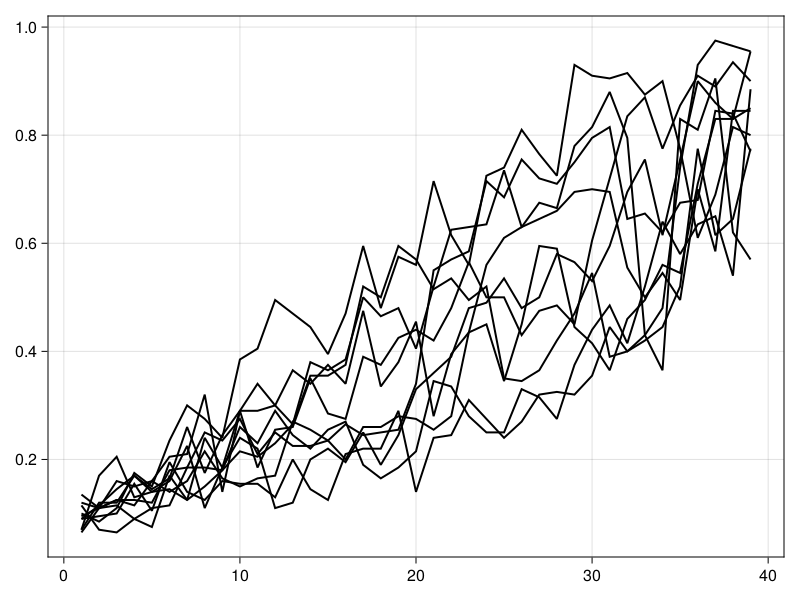

In [1607]:
series(psw, solid_color = :black)

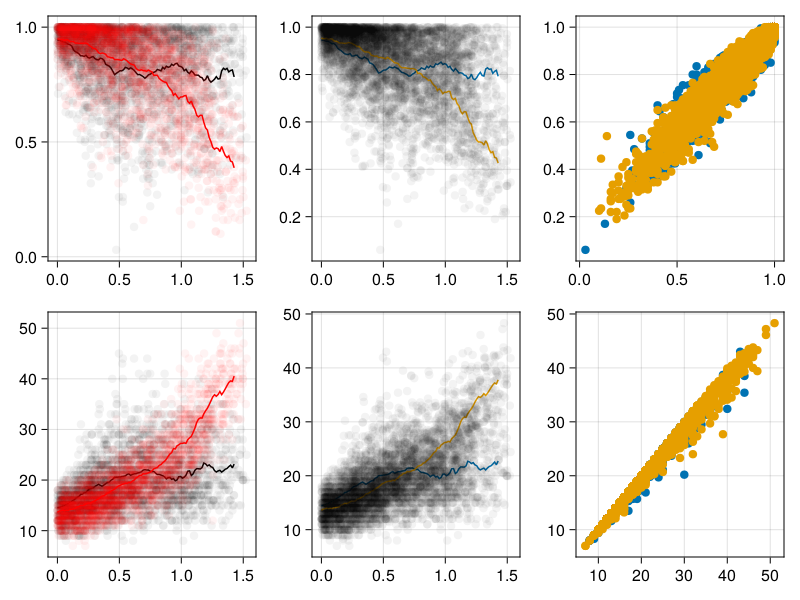

In [1490]:
moving_average(t,x,w,vec) = [ x[(t .>= τ) .& (t .< τ+w)] |> mean for τ = vec]

T = temp_results[:]
w = 0.1
vec = range(minimum(T), maximum(T)-w, length = 100)
# vec = unique(temp_results[:,1])

f = Figure()
ax1 = Axis(f[1,1])
ax2 = Axis(f[2,1])
ax3 = Axis(f[1,2])
ax4 = Axis(f[2,2])
ax5 = Axis(f[1,3])
ax6 = Axis(f[2,3])

for i = 1:2

    psw = psw_results[:,2,i,:][:]
    scatter!(ax1, T, psw, color = ([:black,:red][i], 0.05))
    lines!(ax1, vec, moving_average(T,psw,w,vec), color = [:black,:red][i])

    N = N_results[:,2,i,:][:]
    scatter!(ax2, T, N, color = ([:black,:red][i], 0.05))
    lines!(ax2, vec, moving_average(T,N,w,vec), color = [:black,:red][i])
    
    psw = psw_results[:,3,i,:][:]
    lines!(ax3, vec, moving_average(T,psw,w,vec))
    scatter!(ax3, T, psw, color = (:black, 0.05))

    N = N_results[:,3,i,:][:]
    lines!(ax4, vec, moving_average(T,N,w,vec))
    scatter!(ax4, T, N, color = (:black, 0.05))

    scatter!(ax5, psw_results[:,2,i,:][:], psw_results[:,3,i,:][:])
    scatter!(ax6, N_results[:,2,i,:][:], N_results[:,3,i,:][:])
end

f

In [1611]:
reshape(psw_results,:)

150-element Vector{Float64}:
 1.0
 0.95
 0.9
 0.88
 0.95
 0.98
 0.9
 0.86
 0.95
 0.9
 0.9
 0.96
 0.95
 ⋮
 0.8400000000000001
 0.9850000000000001
 0.9650000000000001
 0.8949999999999999
 0.49000000000000005
 0.8150000000000001
 0.7950000000000002
 0.845
 0.7049999999999998
 0.9200000000000002
 0.6649999999999999
 0.145

In [1617]:
temp_results

25×1 Matrix{Float64}:
 0.036370142765095495
 0.07635193595128255
 0.08848865111741507
 0.11623710726583632
 0.12445691012700419
 0.18055048999372694
 0.1966060606466899
 0.235710907340837
 0.28963661602604424
 0.32379060374545743
 0.32763768056489456
 0.5700360305839743
 0.5836269176654507
 0.6556184712204152
 0.6582328357417613
 0.660551075437399
 0.6926945687242984
 0.6949594616104345
 0.8230495021386164
 0.8801323154918702
 0.95069794702269
 1.0742068088659391
 1.103851933731554
 1.146429393425853
 1.314968094613831

# Results

## main results

In [10]:
time = repeat([0,1], inner = 50, outer = 2)
treatment = repeat([0,1], inner = 100)

mean_log(x) = mean(map(log, x))

for N = 1
    for C = 1
        for a = 1
            for chunk = 1:10
                println(C, a, chunk)
                fn = join(["../Data/psw_test/simulations_",N,"_",C,"_",a,"_",chunk,".jld2"])
                r = load(fn)

                N_mat = length.(r["bodysize"])
                N_mat = vcat(N_mat[:,:,1,1], N_mat[:,:,1,2],N_mat[:,:,2,1],N_mat[:,:,2,2])
                N_mat = hcat(time, treatment, N_mat)

                bs_mat = mean_log.((r["bodysize"]))
                bs_mat = vcat(bs_mat[:,:,1,1], bs_mat[:,:,1,2],bs_mat[:,:,2,1],bs_mat[:,:,2,2])
                bs_mat = hcat(time, treatment, bs_mat)

                psw_mat = r["psw"]
                psw_mat = vcat(psw_mat[:,:,1,1], psw_mat[:,:,1,2],psw_mat[:,:,2,1],psw_mat[:,:,2,2])
                psw_mat = hcat(time, treatment, psw_mat)


                fn_N = join(["../Data/psw_test_csv/N_simulation_",N,"_",C,"_",a,"_",chunk,".csv"])
                fn_bs = join(["../Data/psw_test_csv/bs_simulation_",N,"_",C,"_",a,"_",chunk,".csv"])
                fn_psw = join(["../Data/psw_test_csv/psw_simulation_",N,"_",C,"_",a,"_",chunk,".csv"])


                writedlm(fn_N, N_mat)
                writedlm(fn_bs, bs_mat)
                writedlm(fn_psw, psw_mat)
            end
        end
    end
end

111
112
113
114
115
116
117
118
119
1110


In [1699]:
function foodweb_layout(g)
    # ny = rand(size(g)[1])
    # ny = get_shortestpath(g)
    ny = get_TL(g)
    
    #bin
    bin_n = bin_vec(ny)
    nx = space_bins(bin_n)
    
    return(Point.(zip(nx, ny)))
end

function bin_vec(x; min_val = minimum(x), max_val = maximum(x), nbins = 10)
    #get bin boundaries
    boundaries = range(min_val, max_val + 1e-1,length = nbins)

    #itterate through and get bins
    y = similar(x)
    for i = eachindex(x)
        y[i] = findfirst((x[i] .- boundaries) .<= 0)
    end

    return(y)
end

function space_bins(bins)
    bins_dict = Dict(k => 1 for k = unique(bins))
    x_pos = similar(bins)

    for i = eachindex(bins)
        x_pos[i] = bins_dict[bins[i]]
        bins_dict[bins[i]] += 1
    end

    #normalise in each group
    for g = unique(bins)
        indx = findall(bins .== g)
        x_pos[indx] .= (x_pos[indx] .- mean(x_pos[indx]))
    end

    return(x_pos)

end







space_bins (generic function with 1 method)

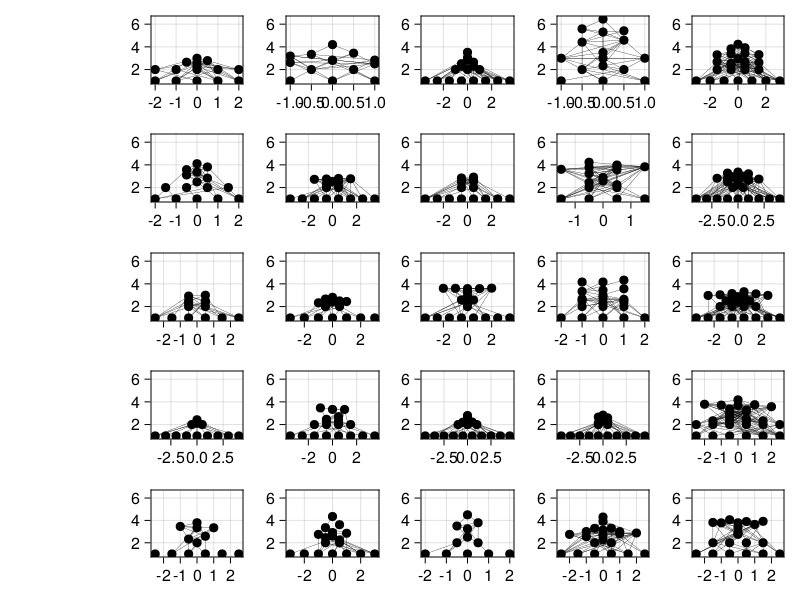

In [1710]:
readdir("../Data/ODE_webs/")

rep = 1
t = 2
treat = 2
com = 1

fig = Figure()

k = 1
for i = 1:5:25
    global k +=1
    for rep = 1:5

    ax = Axis(fig[rep,k])
    
    fn = join(["../Data/ODE_webs/Web",rand(1:100),t,treat,i,".csv"],"_")
    A = readdlm(fn)
    
    g = MetaDiGraph(SimpleDiGraph(A))

    # println(get_TL(g))
    
    graphplot!(ax, g, layout = foodweb_layout, edge_width = 0.3, arrow_size = 0, node_size = 13)
    end
end

linkyaxes!(fig.content...)

fig

In [1784]:
function get_sp_data(mc)

    sp_indx = 1:length(mc.sp_id)
    
    #get locations
    sp_loc = [mc.sp_loc[id] for id = mc.sp_id]
    sp_loc[isempty.(sp_loc)] .= [[0]]
    sp_loc = vcat(sp_loc...)
    
    #get temp
    com_T = [l == 0 ? 0 : mc.T_mat[l] for l = sp_loc]
    
    #get original
    sp_T = [s.Tpk for s = mc.sp]
    
    #get traits
    sp_n = [s.n for s = mc.sp]
    sp_c = [s.c for s = mc.sp]
    sp_r = [s.r for s = mc.sp]
    
    
    return( hcat(sp_indx, sp_loc, com_T, sp_T, sp_n, sp_c, sp_r) )
end

get_sp_data (generic function with 1 method)

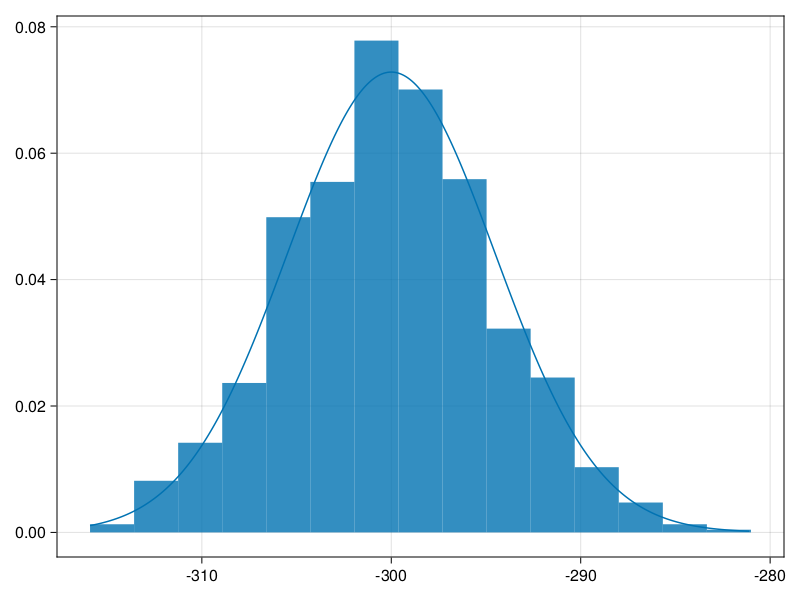

In [1854]:
x = rand(LogNormal(-10,1), 30, 1000)

f = Figure()
ax = Axis(f[1,1])
sums = sum(log.(x), dims = 1)[:]
hist!(ax, sums, normalization = :pdf)

dapp = Normal(-10 * 30, sqrt(1 * 30))
s = minimum(sums):0.1:maximum(sums)
pdf_ = pdf.(dapp, s)
lines!(ax, s, pdf_)


f

In [1853]:
sums |> var

32.066454565618486

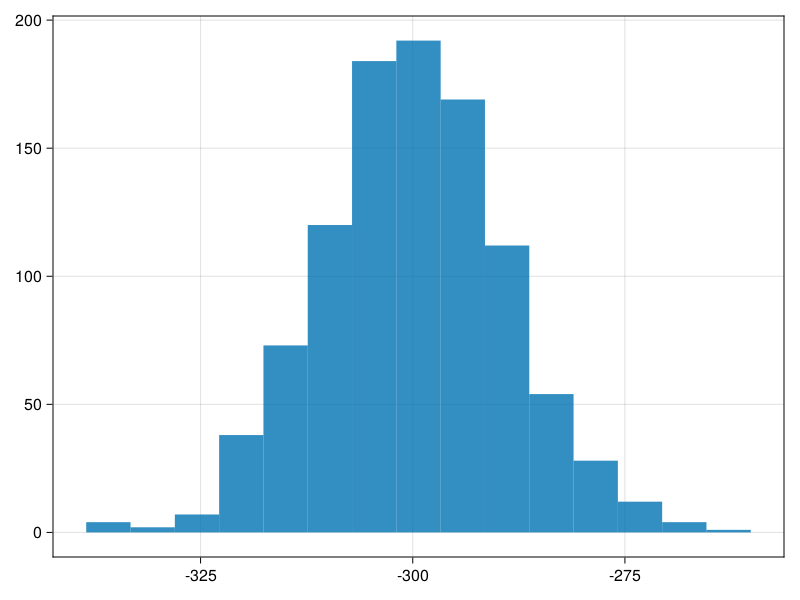

In [1828]:
hist(sum(log.(x), dims = 1)[:])

## Multiple simulations

In [9]:
time = repeat([0,1], inner = 50, outer = 2)
treatment = repeat([0,1], inner = 100)

for N = 1:3
    for C = 1:3
        for a = 1:5
            for chunk = 1:5
                println(C, a, chunk)
                fn = join(["../Data/psw_sensitvity/simulations_",N,"_",C,"_",a,"_",chunk,".jld2"])
                r = load(fn)

                N_mat = length.(r["bodysize"])
                N_mat = vcat(N_mat[:,:,1,1], N_mat[:,:,1,2],N_mat[:,:,2,1],N_mat[:,:,2,2])
                N_mat = hcat(time, treatment, N_mat)

                bs_mat = mean.(r["bodysize"])
                bs_mat = vcat(bs_mat[:,:,1,1], bs_mat[:,:,1,2],bs_mat[:,:,2,1],bs_mat[:,:,2,2])
                bs_mat = hcat(time, treatment, bs_mat)

                psw_mat = r["psw"]
                psw_mat = vcat(psw_mat[:,:,1,1], psw_mat[:,:,1,2],psw_mat[:,:,2,1],psw_mat[:,:,2,2])
                psw_mat = hcat(time, treatment, psw_mat)


                fn_N = join(["../Data/psw_sensitvity_csv/N_simulation_",N,"_",C,"_",a,"_",chunk,".csv"])
                fn_bs = join(["../Data/psw_sensitvity_csv/bs_simulation_",N,"_",C,"_",a,"_",chunk,".csv"])
                fn_psw = join(["../Data/psw_sensitvity_csv/psw_simulation_",N,"_",C,"_",a,"_",chunk,".csv"])


                writedlm(fn_N, N_mat)
                writedlm(fn_bs, bs_mat)
                writedlm(fn_psw, psw_mat)
            end
        end
    end
end

111
112
113
114
115
121
122
123
124
125
131
132
133
134
135
141
142
143
144
145
151
152
153
154
155
211
212
213
214
215
221
222
223
224
225
231
232
233
234
235
241
242
243
244
245
251
252
253
254
255
311
312
313
314
315
321
322
323
324
325
331
332
333
334
335
341
342
343
344
345
351
352
353
354
355
111
112
113
114
115
121
122
123
124
125
131
132
133
134
135
141
142
143
144
145
151
152
153
154
155
211
212
213
214
215
221
222
223
224
225
231
232
233
234
235
241
242
243
244
245
251
252
253
254
255
311
312
313
314
315
321
322
323
324
325
331
332
333
334
335
341
342
343
344
345
351
352
353
354
355
111
112
113
114
115
121
122
123
124
125
131
132
133
134
135
141
142
143
144
145
151
152
153
154
155
211
212
213
214
215
221
222
223
224
225
231
232
233
234
235
241
242
243
244
245
251
252
253
254
255
311
312
313
314
315
321
322
323
324
325
331
332
333
334
335
341
342
343
344
345
351
352
353
354
355


In [99]:
#turnover
function jacc(id1,id2; method = :total)
    if method == :total
        return(length(intersect(id1,id2)) / length(union(id1,id2)))
    elseif method == :new
        return( sum(.!in.(id1, Ref(id2))) / length(union(id1,id2)) )
    elseif method == :out
        return( sum(.!in.(id2, Ref(id1))) / length(union(id1,id2)) )
    end
end

jacc (generic function with 1 method)

# Results

Here we have the results from the simulations. Across the communties we see a clear pattern of stability in the allometric (i.e. constrained) and the random dispersal. 

The allometric generally shows reduced stability at higher lattitudes presumably because of the influx more species.

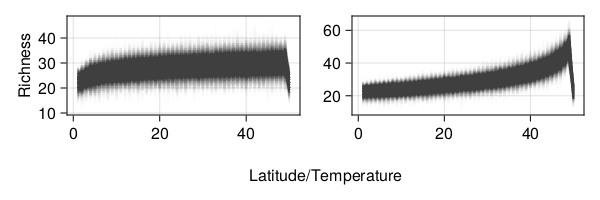

In [100]:
#richness
fig = Figure(resolution = (600,200))

ax = Axis(fig[1,1], ylabel = "Richness")
series!(ax, N_mat[:,:,1,2]', solid_color = (:black, 0.01))

ax = Axis(fig[1,2])
series!(ax, N_mat[:,:,2,2]', solid_color = (:black, 0.01))

Label(fig[2,1:2], "Latitude/Temperature")

fig

In [93]:
# #turnover - use bs as proxy for now
# res_bs = r["bodysize"]
# turnover = zeros(N_T, N_rep, 2)

# for r = 1:N_rep
#     for p = 1:2
#         turnover[:,r,p,1] .= [jacc(res_bs[T,r,p,1], res_bs[T,r,p,2], method = :total) for T = 1:N_T]
#     end
# end

# fig = Figure(resolution = (600,200))

# ax = Axis(fig[1,1])
# series!(ax, turnover[:,:,1], solid_color = (:black, 0.1))

# ax = Axis(fig[1,2])
# series!(ax, turnover[:,:,2], solid_color = (:black, 0.1))

# fig

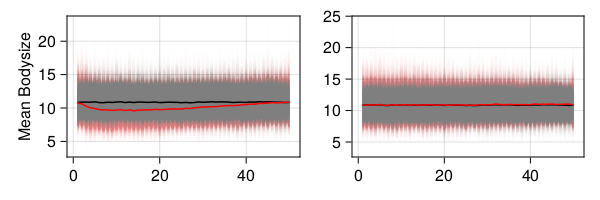

In [107]:
#bodysize
fig = Figure(resolution = (600,200))
ax = Axis(fig[1,1], ylabel = "Mean Bodysize")
series!(ax, bs_mat[:,:,1,1]', solid_color = (:black, 0.005))
series!(ax, bs_mat[:,:,1,2]', solid_color = (:red, 0.005))

lines!(ax,1:N_T, bs_mean[:,1,1,1], color = :black)
lines!(ax,1:N_T, bs_mean[:,1,1,2], color = :red)

ax = Axis(fig[1,2])
series!(ax, bs_mat[:,:,2,1]', solid_color = (:black, 0.005))
series!(ax, bs_mat[:,:,2,2]', solid_color = (:red, 0.005))

lines!(ax,1:N_T, bs_mean[:,1,2,1], color = :black)
lines!(ax,1:N_T, bs_mean[:,1,2,2], color = :red)

linkaxes!.(fig.content)

fig


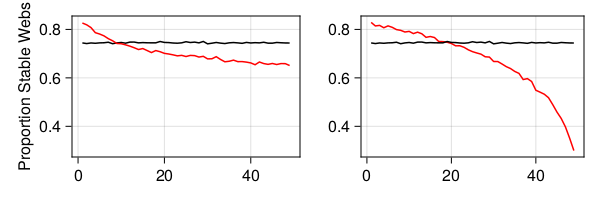

In [102]:
#psw
fig = Figure(resolution = (600,200))
ax = Axis(fig[1,1], ylabel="Proportion Stable Webs")

T_lim = 1:N_T-1

# series!(ax, 1:N_T, psw_mat[:,:,1,1]', solid_color = (:black, 0.01))
# series!(ax, 1:N_T, psw_mat[:,:,1,2]', solid_color = (:red, 0.01))

lines!(ax,T_lim, mean(psw_mat, dims = 2)[T_lim,1,1,1], color = :black)
lines!(ax,T_lim, mean(psw_mat, dims = 2)[T_lim,1,1,2], color = :red)


ax = Axis(fig[1,2])
# series!(ax, 1:N_T, psw_mat[:,:,2,1]', solid_color = (:black, 0.01))
# series!(ax, 1:N_T, psw_mat[:,:,2,2]', solid_color = (:red, 0.01))

lines!(ax,T_lim, mean(psw_mat, dims = 2)[T_lim,1,2,2], color = :red)
lines!(ax,T_lim, mean(psw_mat, dims = 2)[T_lim,1,2,1], color = :black)


linkaxes!(fig.content...)

fig

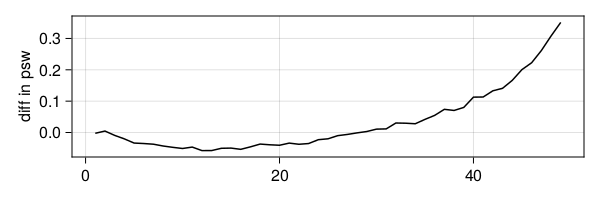

In [103]:
fig = Figure(resolution = (600,200))
ax = Axis(fig[1,1], ylabel = "diff in psw")

lines!(ax,T_lim, mean(psw_mat, dims = 2)[T_lim,1,1,2] .- mean(psw_mat, dims = 2)[T_lim,1,2,2], color = :black)

fig

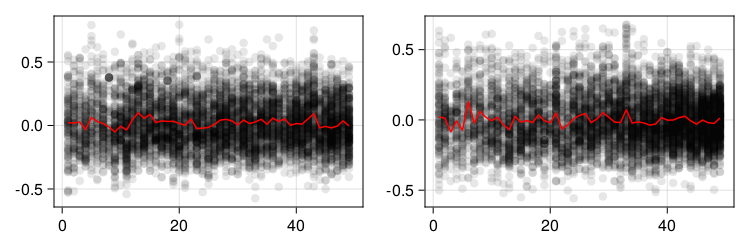

In [22]:
#types of instability
cor_mat = fill(Float64[], N_T-1, N_rep, 2)

for i = 1:2
    for T = T_lim
        for rep = 1:N_rep
            #get values
            λvals = real.(r["vals"][T,rep,i,2])

            unstable = findall(λvals .>= 0)

            if length(unstable) > 0
                unstable_vecs = norm.(r["vecs"][T,rep,i,2][unstable, :])
                bs_vec = r["bodysize"][T,rep,i,2]

                cor_mat[T,rep,i] = mapslices(x -> cor(x,bs_vec) , unstable_vecs, dims = 2)[:]
            end
        end
    end
end

fig = Figure(resolution = (750,250))
ax1 = Axis(fig[1,1])
ax2 = Axis(fig[1,2])

for T = T_lim
    for rep = 1:N_rep
        if length(cor_mat[T,rep,1]) > 0
            scatter!(ax1, fill(T, length(cor_mat[T,rep,1])), cor_mat[T,rep,1], color = (:black, 0.1))
        end
        
         if length(cor_mat[T,rep,2]) > 0
            scatter!(ax2, fill(T, length(cor_mat[T,rep,2])), cor_mat[T,rep,2], color = (:black, 0.1))
        end
        
    end
end

cor_mean = map(x -> mean(filter(!isnan,x)), cor_mat)
cor_mean = mapslices(x -> mean(filter(!isnan,x)), cor_mean, dims = 2)

lines!(ax1, T_lim, cor_mean[:,1,1], color = "red")
lines!(ax2, T_lim, cor_mean[:,1,2], color = "red")

fig

# Foodweb Plotting

In [627]:
function foodweb_layout(g)
    ny = 1 .- g.gprops[:n]
    nx = rand(length(g.gprops[:n]))
    return(Point.(zip(nx, ny)))
end

foodweb_layout (generic function with 1 method)

In [628]:
#plotting
stable_coms = [communities[i,x[2]] for (i,x) = enumerate(stable_indx)]

#convert to graphs
g_vec = Vector{Any}(undef, N_temp)
for (i,sc) = enumerate(stable_coms)
    g = MetaDiGraph(SimpleDiGraph(sc.A))
    set_prop!(g, :n, [x.n for x = sc.sp])
    
    g_vec[i] = g
end

LoadError: UndefVarError: `stable_indx` not defined

In [629]:
f = Figure()

ax = [Axis(f[i % 5,(i ÷ 5)]) for i = 1:N_temp]

[graphplot!(ax[i],g_vec[i], layout=foodweb_layout, edge_width = 0.3, arrow_size = 0.0, node_size = 5) for i = 1:N_temp]
hidedecorations!.(ax); hidespines!.(ax)
[ax[i].aspect = DataAspect() for i = 1:N_temp]

f

LoadError: UndefVarError: `N_temp` not defined

In [54]:
#calculate sp_occurance
result = Vector{Any}(undef, length(sp_vec))
id_sp = Dict{Base.UUID,Vector{Any}}()

for i = CartesianIndices(stable_coms)
    for s = communities[i].sp
        if s.id in keys(id_sp)
            push!(id_sp[s.id], i)
        else
            id_sp[s.id] = [i]
        end
    end
end


In [242]:
function resolve_extinction(com)
    gp = 0
    λ = Vector{Eigen}(undef, 1)
    J = zeros(com.N,com.N)

   stable = true

    while stable
        gp = fw.generalised_parameters(com, 1, exp_parameters)
        fw.generalised_jacobian!(J,gp[1])
        λ[1] = eigen!(J)
        
        x = typeof(λ[1].values[end]) <: AbstractFloat ? λ[1].values[end] : λ[1].values[end].re
        # println(x)
        if x > 0
            stable = false
        end
    end
        

    #simulate and get new community
    k = fw.get_kineticparams(gp[1])
    
    #integrate
    u0 = ones(k.N) ./ 100
    tspan = (0.0, 1e4)
    cb = CallbackSet(PositiveDomain(), TerminateSteadyState())
    prob = ODEProblem(fw.dx!, u0, tspan, (k, LazyBufferCache()))
    sol = solve(prob, callback = cb)
    return(sol)
end

resolve_extinction (generic function with 1 method)

In [243]:
coms = fw.community(20,0.2)

FoodWebs.Community N:20 T:0.5

In [244]:
# Random.seed!(1)
sol = resolve_extinction(coms);

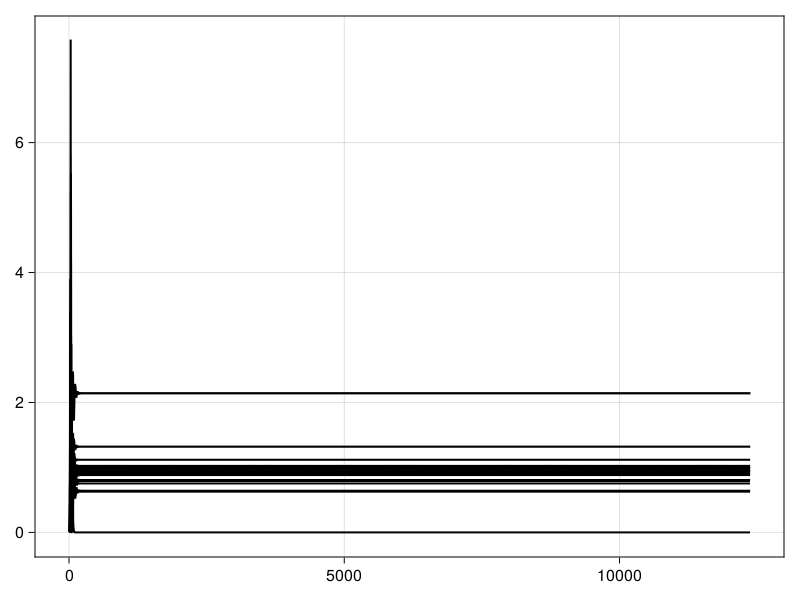

In [245]:
series(sol[:,:], solid_color = "black")

In [287]:
A = [-1 0 0 ; 1 -1 0; 0 1 -1]
r = [1 ; 0 ; 0]

x = -inv(A) * r

3-element Vector{Float64}:
 1.0
 1.0
 1.0

In [289]:
A*x + r

3-element Vector{Float64}:
 0.0
 0.0
 0.0

In [308]:
a = A'[:]
E = zeros(length(r), length(a))

ind = 1:length(r):length(a)

for i = 1:length(r)
    E[i,ind[i]:(ind[i]+2)] .= x 
end



LoadError: DimensionMismatch: matrix is not square: dimensions are (3, 9)

In [646]:
l = 1
d =4

function simplex_volume(l::Array{Float64},d::Int64) 
    v = [zeros(d) for i = 1 : (d+1)]
    [v[i][i-1] = l[i-1] for i = 2 : (d+1)]
    
    B = zeros(d+2 , d+2)
    [B[i+1,j+1] = norm(v[i] - v[j])^2 for i = 1:(d+1), j = 1:(d+1)]
    
    B[2:end,1] .= 1
    B[1, 2:end] .= 1
    
    p = (-1)^(d+1) / ((2^d) * factorial(d)^2)
    
    sqrt(p * det(B))
end



simplex_volume (generic function with 2 methods)

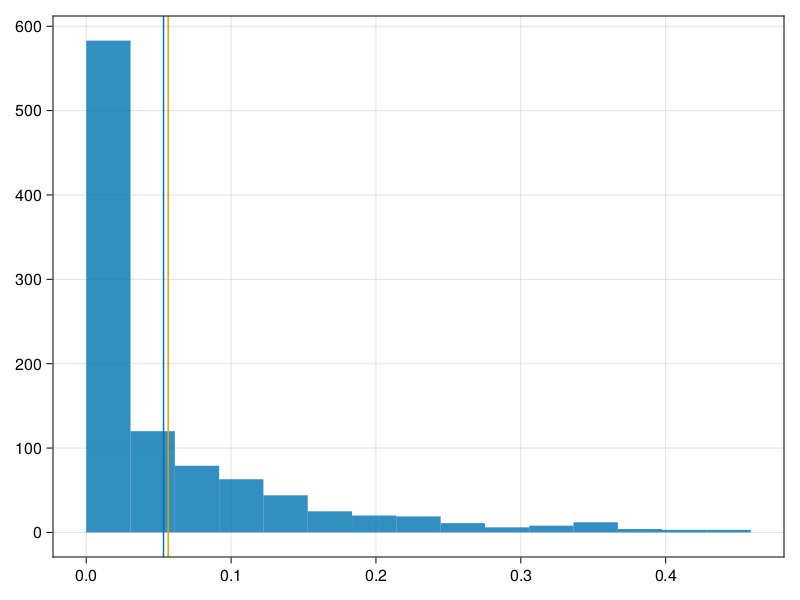

In [679]:
N = 2
Vr = [simplex_volume(rand(N) .^ 2, N) for i = 1:1000]
Vs = simplex_volume(fill(mean(rand(100).^2),N),N)

f,ax = hist(Vr)

vlines!(ax, Vs)
vlines!(ax, mean(Vr))
f

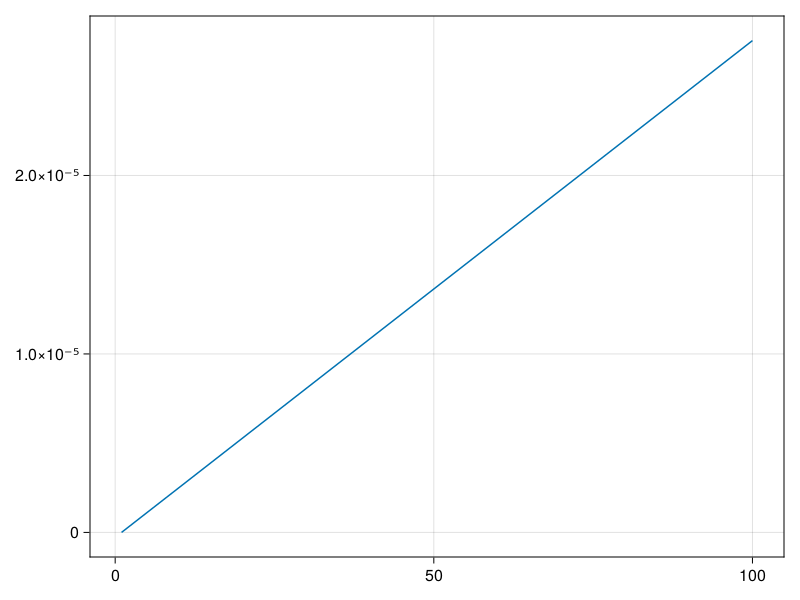

In [691]:
d = 10
l = ones(d)
v = zeros(100)

for i = 1:100
    l[1] = range(0,100, length = 100)[i]
    v[i] = simplex_volume(l, d)
end

lines(v)


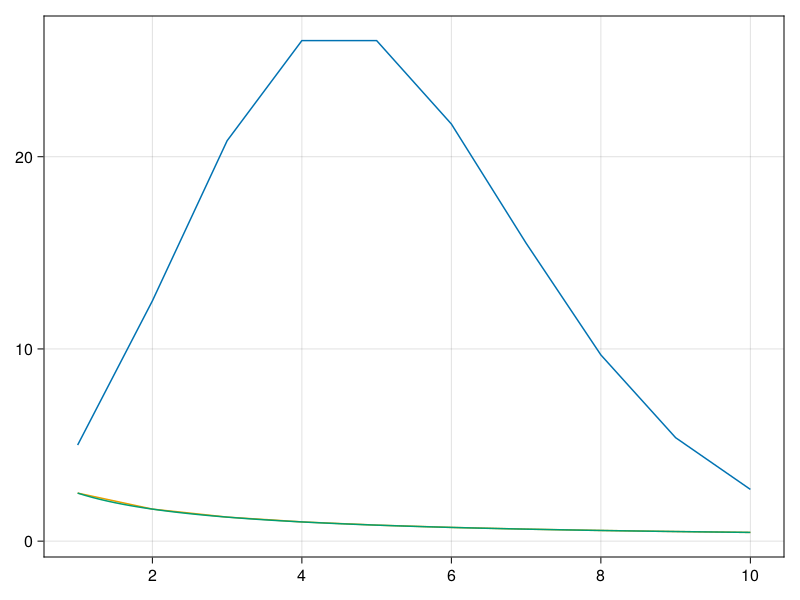

In [642]:
l = 5
f,ax = lines([l^d / factorial(d) for d = 1:10])
lines!(ax,[simplex_volume(l,d) for d = 2:11] ./ [simplex_volume(l,d) for d = 1:10])
lines!(ax,1:0.1:10,  [l / (d+1) for d = 1:0.1:10])

f

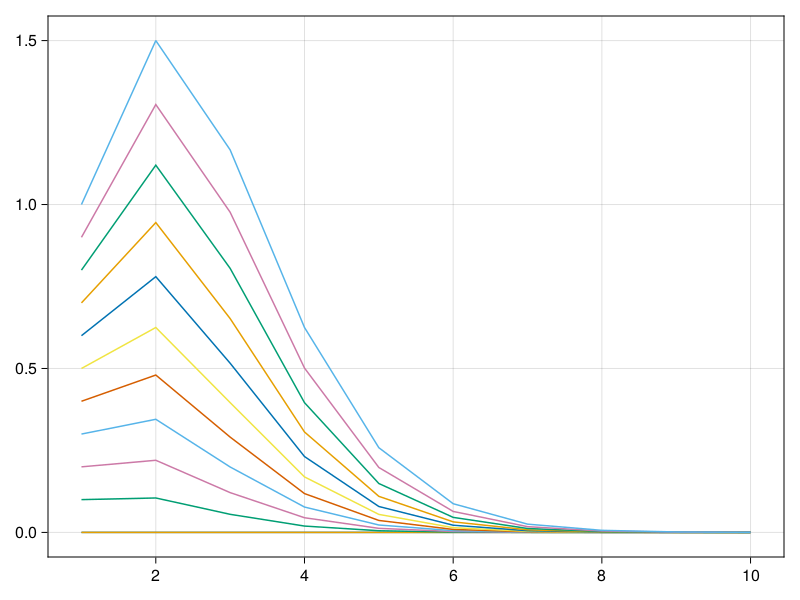

In [645]:
f,ax = lines(([((1^d) - (1^d)) / factorial(d) for d = 1:10]))
[lines!(ax,([((k^d) - (1^d)) / factorial(d) for d = 1:10])) for k = 1:0.1:2.0]
f

In [1]:
Nfeas = 1000
Ninv = 100
feas = zeros(Nfeas, Ninv)

#one producer
N = 1
A = fill(-1.0, 1, 1)
r = ones(N)
x = -inv(A)*r

function sample_space(N,A, Ninv)
    #new r
    r = zeros(N+1)
    r[1] = 1.0

    B = []
    
    for i = 1:Ninv
        #new A
        a = rand(N+1,N+1) / 10
        a[:,end] .= -a[end,:]
        a[end,end] = -1.0
        a[1:N, 1:N] .= A
    
        x_new = -inv(a)*r
    
        if all(x_new .> 0)
            push!(B,sample_space(N+1,a,Ninv))
        end
    end
    return(1,B...)
end

x = sample_space(1,A,2);


In [798]:
A = x[end-2][1]
r = x[end-2][2]

-inv(A)  * r

12-element Vector{Float64}:
 0.9687295053179307
 0.047410691418000715
 0.01958138578593775
 0.0007880079003367063
 0.07970096463220482
 0.012243439230398478
 0.04806285480303854
 0.047174323761299986
 0.06720786296976307
 0.06137072938251742
 0.0827703721049486
 0.038587917642492656

In [ ]:
x

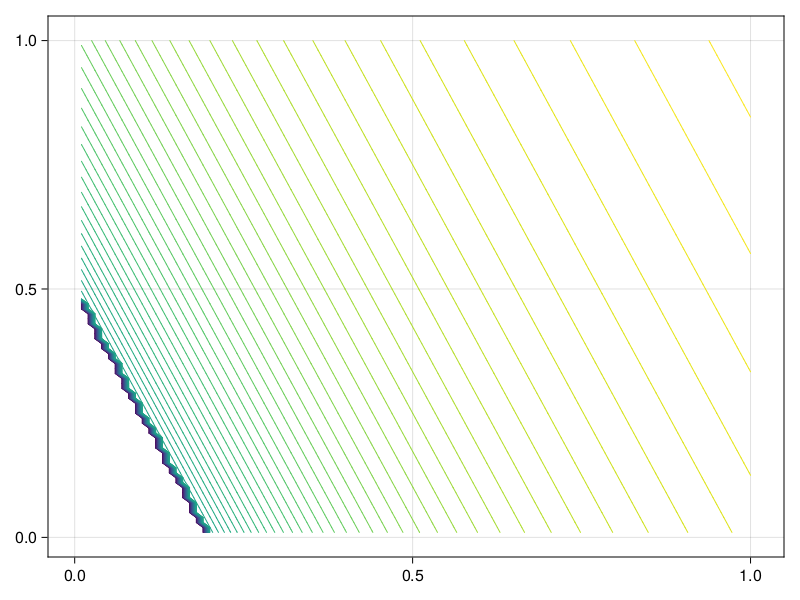

In [487]:
x_eq = [5.0,2.0]
#interactions
a = [Point2f(i/100, j/100) for i = 1:100, j = 1:100][:]

#upper bound
ub = [sum(a[k]) <= 5 for k = eachindex(a)]

#intake
I = [sum(a[k] .* x_eq) / (sum(a[k] .* x_eq) + 1) for k = eachindex(a)]

#diet
d = [I[k] > 0.5 for k = eachindex(a)]

contour([x[1] for x=a],[x[2] for x=a],  I .* ub .* d, levels=0.0:0.01:1)

In [607]:
function get_niche_volume(N,x,K)
#in normalised space
    Na = Int(1e3)
    #get constrained a_sample
    a_sample_constrained = [rand(N) for i = 1:Na]#[rand() .* rand(Dirichlet(N, 1.0)) for i = 1:Na];
    #convert to intake rates
    I = [(K*a_sample_constrained[i]) .* (x) for i = 1:Na]
    #get prop above threshold
    mean( (sum.(I) .> 0.5) .& (sum.(a_sample_constrained) .<= 1)  ) 
end

get_niche_volume (generic function with 1 method)

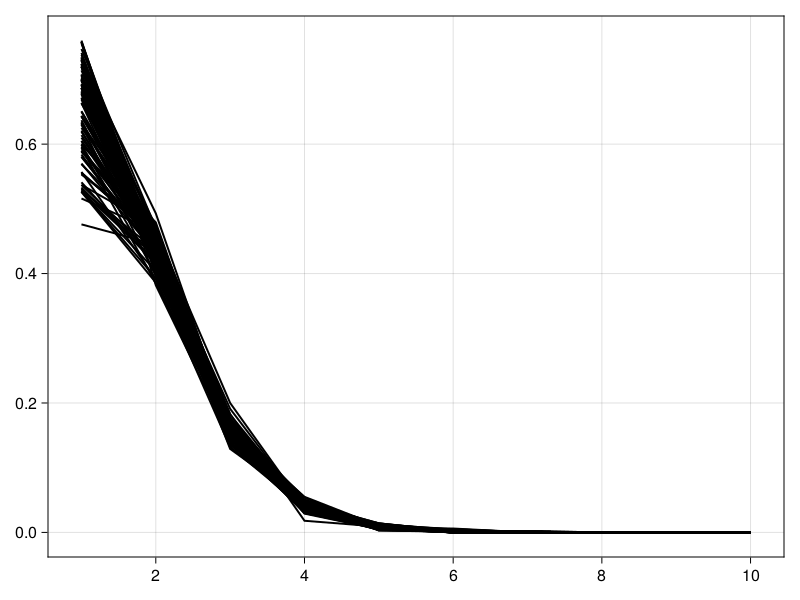

In [613]:
#number of species
N = 4
#eqilibrium
K = 1.0

series(hcat([[get_niche_volume(N,rand(N) .+ 1.0,K) for j = 1:100] for N = 1:10]...), solid_color = :black)

In [10]:
T_mat = 1:10

x = (T_mat' .- T_mat)

x[1,10]

9